In [295]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [296]:
def ADT_classification_mean_std(results):
    """Calculate for each bh_ratio the mean percentage and 1 sigma error
    for alive, transient AND DEAD systems"""
    res=[]
    states = ['alive', 'transient', 'dead']
    total_systems
    for bh in results['bh_ratio'].unique():
        for state in states:
            cut = results[results['bh_ratio']==bh]
            std_dev = np.std(cut[state])
            mean = np.mean(cut[state])
            res.append([bh, state, mean/500*100, std_dev/500*100])
            
    df_res = pd.DataFrame(res)
    df_res.columns=['bh_ratio', 'classification', 'mean', 'error']
    return df_res

In [297]:
def process_AT_results(results):
    """Calculate for each bh_ratio the mean percentage and 1 sigma error
    for ONLY Alive & Transient results
    """
    res=[]
    states = ['alive', 'transient']
    for bh in results['bh_ratio'].unique():
        for state in states:
            cut = results[results['bh_ratio'] == bh]
            state_avg_number_of_systems = np.mean(cut[state])
            alive_and_dead_avg_number_of_systems = np.mean(cut['alive'] + cut['transient'])
            
            state_std_dev = np.std(cut[state])

            res.append([bh,
                        state,
                        state_avg_number_of_systems/alive_and_dead_avg_number_of_systems*100,
                        state_std_dev/alive_and_dead_avg_number_of_systems*100])
    df_res = pd.DataFrame(res)
    df_res.columns=['bh_ratio', 'classification', 'mean', 'error']
    return df_res

In [298]:
def plot_ADT(df_res, Z, axarr, arr_row, arr_col):
    alive_fmt = '-'
    dead_fmt =  '--'
    transient_fmt = ':'

    df_res_alive = df_res[df_res['state'] == 'alive']
    df_res_dead = df_res[df_res['state'] == 'dead']
    df_res_trans = df_res[df_res['state'] == 'transient']
    
    axarr[arr_row, arr_col].text(x=0.1, y=5, s=f'Z = {Z}')
    axarr[arr_row, arr_col].set_xlabel('$\%_{BH}$')
    axarr[arr_row, arr_col].set_ylabel('% of systems')
    axarr[arr_row, arr_col].set_ylim(0, 100)
    
    axarr[arr_row, arr_col].plot(100*df_res_alive['bh_ratio'], df_res_alive['mean'],
         label='Alive', color='black',
         linestyle=alive_fmt, linewidth=0.8)
    
    axarr[arr_row, arr_col].plot(100*df_res_dead['bh_ratio'], df_res_dead['mean'],
         label='Dead', color='black',
         linestyle=dead_fmt, linewidth=0.8)
    
    axarr[arr_row, arr_col].plot(100*df_res_trans['bh_ratio'], df_res_trans['mean'],
         label='Transient', color='black',
         linestyle=transient_fmt, linewidth=0.8)
    
    
#    axarr[arr_row, arr_col].errorbar(df_res_alive['BH_ratio'], df_res_alive['mean'],
#         yerr=df_res_alive['error'], capsize=1.0, color='black',
#         fmt='none', elinewidth=0.25)
#    
#    axarr[arr_row, arr_col].errorbar(df_res_dead['BH_ratio'], df_res_dead['mean'],
#         yerr=df_res_dead['error'], capsize=1.0, color='black',
#         fmt='none', elinewidth=0.25)
#        
#    axarr[arr_row, arr_col].errorbar(df_res_trans['BH_ratio'], df_res_trans['mean'],
#         yerr=df_res_trans['error'], capsize=1.0, color='black',
#         fmt='none', elinewidth=0.25)
    
    axarr[arr_row, arr_col].legend(loc='right', prop={'size': 8})
#    plt.savefig('../reports/figures/ADT_BHNS_Z_{}.png'.format(Z), format='png', dpi=1000)
#    plt.savefig('../reports/figures/ADT_BHNS_Z_{}.eps'.format(Z), format='eps')
#    plt.savefig('../reports/figures/ADT_BHNS_Z_{}.pdf'.format(Z), format='pdf')

In [299]:
def plot_AT(df_res, Z, axarr, arr_row, arr_col):
    alive_color = 'black'
    transient_color = 'grey'
    
    #Code for these figures are in /reports/investigations.ipynb
    PERCENT_ALIVE_EARNSHAW = 0.8271604938271605 * 100
    PERCENT_ALIVE_EARNSHAW_ERROR = 0.12256472421344072 * 100
    
    PERCENT_ALIVE_EARNSHAW_UPPER = PERCENT_ALIVE_EARNSHAW + PERCENT_ALIVE_EARNSHAW_ERROR
    PERCENT_ALIVE_EARNSHAW_LOWER = PERCENT_ALIVE_EARNSHAW - PERCENT_ALIVE_EARNSHAW_ERROR
    
    PERCENT_TRANS_EARNSHAW = 0.1728395061728395 * 100
    PERCENT_TRANS_EARNSHAW_ERROR = 0.03744750536124969 * 100
    PERCENT_TRANS_EARNSHAW_UPPER = PERCENT_TRANS_EARNSHAW + PERCENT_TRANS_EARNSHAW_ERROR
    PERCENT_TRANS_EARNSHAW_LOWER = PERCENT_TRANS_EARNSHAW - PERCENT_TRANS_EARNSHAW_ERROR
    
    #Filtering dfs by state
    df_res_alive = df_res[df_res['classification'] == 'alive']
    df_res_trans = df_res[df_res['classification'] == 'transient']
    
    #Curve Fitting
    def func(x, m, c):
        return m*x + c
    
    def func_inv(y, m, c):
        return (y - c) / m

    res_alive = curve_fit(func, df_res_alive['bh_ratio'], df_res_alive['mean'], sigma=df_res_alive['error'])
    res_trans = curve_fit(func, df_res_trans['bh_ratio'], df_res_trans['mean'], sigma=df_res_trans['error'])
    
    m_alive = res_alive[0][0]
    c_alive = res_alive[0][1]
    
    m_trans = res_trans[0][0]
    c_trans = res_trans[0][1]
    
    x = np.arange(0, 1, 0.001)
    y_alive = [func(i, m_alive, c_alive) for i in x]
    y_trans = [func(i, m_trans, c_trans) for i in x]
    
    # Plotting
    
    # Plot errorbars
    axarr[arr_row, arr_col].errorbar(100*df_res_alive['bh_ratio'], df_res_alive['mean'],
         yerr=df_res_alive['error'], label='Always visible', capsize=1.0, color=alive_color,
         fmt='x', elinewidth=0.8, markersize=3)
    
    axarr[arr_row, arr_col].errorbar(100*df_res_trans['bh_ratio'], df_res_trans['mean'],
         yerr=df_res_trans['error'], label='Transient', capsize=1.0, color=transient_color,
         fmt='x', elinewidth=0.8, markersize=3)
    

    
    # Plot Line of best fits
    # axarr[arr_row, arr_col].plot(100*x, y_alive, color='black', linewidth=0.8)
    # axarr[arr_row, arr_col].plot(100*x, y_trans, color='grey', linewidth=0.8)
    
    # Plot Labels and annotations
    axarr[arr_row, arr_col].set_ylim(0, 100)
    
    axarr[arr_row, arr_col].set_xlabel('$\%_{BH}$')
    axarr[arr_row, arr_col].set_ylabel('% of systems')

    axarr[arr_row, arr_col].text(x=0, y=5, s=f'Z = {Z}', fontsize=10)
    # axarr[arr_row, arr_col].text(x=0, y=10, s=f'alive bf: y = {m_alive:.2f}x + {c_alive:.2f}', fontsize=6)
    # axarr[arr_row, arr_col].text(x=0, y=15, s=f'trans bf: y = {m_trans:.2f}x + {c_trans:.2f}', fontsize=6)
    
#    axarr[arr_row, arr_col].text(x=0, y=PERCENT_ALIVE_EARNSHAW+2,
#         s=f'Earnshaw % alive: {PERCENT_ALIVE_EARNSHAW:.2f}+-{PERCENT_ALIVE_EARNSHAW_ERROR:.2f}',
#         fontsize=6)
#    axarr[arr_row, arr_col].text(x=0, y=PERCENT_TRANS_EARNSHAW+2,
#         s=f'Earnshaw % trans: {PERCENT_TRANS_EARNSHAW:.2f}+-{PERCENT_TRANS_EARNSHAW_ERROR:.2f}',
#         fontsize=6)
    
    
    # X values interp
    alive_interp_x = func_inv(PERCENT_ALIVE_EARNSHAW, m_alive, c_alive)
    alive_upper_interp_x = func_inv(PERCENT_ALIVE_EARNSHAW_UPPER, m_alive, c_alive)
    alive_lower_interp_x = func_inv(PERCENT_ALIVE_EARNSHAW_LOWER, m_alive, c_alive)
    
    trans_interp_x = func_inv(PERCENT_TRANS_EARNSHAW, m_trans, c_trans)
    trans_upper_interp_x = func_inv(PERCENT_TRANS_EARNSHAW_UPPER, m_trans, c_trans)
    trans_lower_interp_x = func_inv(PERCENT_TRANS_EARNSHAW_LOWER, m_trans, c_trans)
    
    

    
#    axarr[arr_row, arr_col].hlines(PERCENT_ALIVE_EARNSHAW, xmin=0, xmax=alive_interp_x,
#         color='r', linewidth=0.8, linestyle='--')
#    axarr[arr_row, arr_col].hlines(PERCENT_ALIVE_EARNSHAW_UPPER, xmin=0, xmax=100*alive_upper_interp_x,
#         color='b', linewidth=0.8, linestyle='--')
#    axarr[arr_row, arr_col].hlines(PERCENT_ALIVE_EARNSHAW_LOWER, xmin=0, xmax=100*alive_lower_interp_x,
#         color='b', linewidth=0.8, linestyle='--', color='b', linewidth=0.8)    
#    axarr[arr_row, arr_col].axhline(PERCENT_ALIVE_EARNSHAW_UPPER, color='b', linewidth=0.6,
#                                    linestyle='--', color='b')
    
    axarr[arr_row, arr_col].axhline(PERCENT_ALIVE_EARNSHAW_UPPER, color='g', linewidth=0.6, label=r'Visible $1\sigma$')
    axarr[arr_row, arr_col].axhline(PERCENT_ALIVE_EARNSHAW_LOWER, color='g', linewidth=0.6)
    axarr[arr_row, arr_col].axhline(PERCENT_TRANS_EARNSHAW_UPPER, color='purple', linewidth=0.6, label=r'Transient $1\sigma$')
    axarr[arr_row, arr_col].axhline(PERCENT_TRANS_EARNSHAW_LOWER, color='purple', linewidth=0.6)
    
    
#    axarr[arr_row, arr_col].hlines(PERCENT_TRANS_EARNSHAW, xmin=0, xmax=trans_interp_x,
#         color='r', linewidth=0.8, linestyle='--')
#    axarr[arr_row, arr_col].hlines(PERCENT_TRANS_EARNSHAW_UPPER, xmin=0, xmax=trans_upper_interp_x,
#         color='b', linewidth=0.8, linestyle='--')
#    axarr[arr_row, arr_col].hlines(PERCENT_TRANS_EARNSHAW_LOWER, xmin=0, xmax=trans_lower_interp_x,
#         color='b', linewidth=0.8, linestyle='--')
    
    """
    axarr[arr_row, arr_col].vlines(100*alive_upper_interp_x, ymin=0, ymax=PERCENT_ALIVE_EARNSHAW_UPPER,
         color='b', linewidth=0.8, linestyle='--')
    axarr[arr_row, arr_col].vlines(100*alive_lower_interp_x, ymin=0, ymax=PERCENT_ALIVE_EARNSHAW_LOWER,
         color='b', linewidth=0.8, linestyle='--')
    
    axarr[arr_row, arr_col].text(x=100*alive_upper_interp_x, y=2,
         s=f'{alive_upper_interp_x:.2f}', c='red')
    axarr[arr_row, arr_col].text(x=100*alive_lower_interp_x, y=2,
         s=f'{alive_lower_interp_x:.2f}', c='red')
    """
    
    axarr[arr_row, arr_col].legend(loc='right', prop={'size': 8})

In [300]:
def plot_all_ADT():
    import matplotlib
    fontsize = 14
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    fig, axarr = plt.subplots(2,2, figsize=(6,6))
    plt.gcf().subplots_adjust(bottom=0.15)
    
    plot_ADT(df_adt_Z_002, '0.02', axarr, 0, 0)
    plot_ADT(df_adt_Z_0002, '0.002', axarr, 0, 1)
    plot_ADT(df_adt_Z_00002, '0.0002', axarr, 1, 0)
    plot_ADT(df_adt_Z_all, 'all', axarr, 1, 1)
    plt.tight_layout()
    #plt.savefig('../reports/figures/ADT_BHNS_array.png', format='png', dpi=1000)
    #plt.savefig('../reports/figures/ADT_BHNS_array.eps', format='eps')
    #plt.savefig('../reports/figures/ADT_BHNS_array.pdf', format='pdf')

In [301]:
def plot_all_AT():
    import matplotlib
    fontsize = 14
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    fig, axarr = plt.subplots(2,2, figsize=(6,6))
    plt.subplots_adjust(wspace=0.295)
    
    plot_AT(df_at_Z_002, '0.02', axarr, 0, 0)
    plot_AT(df_at_Z_0002, '0.002', axarr, 0, 1)
    plot_AT(df_at_Z_00002, '0.0002', axarr, 1, 0)
    plot_AT(df_at_Z_all, 'all', axarr, 1, 1)
    plt.savefig('../reports/figures/AT_BHNS_array.png', format='png', dpi=1000)
    plt.savefig('../reports/figures/AT_BHNS_array.eps', format='eps')
    plt.savefig('../reports/figures/AT_BHNS_array.pdf', format='pdf')

In [302]:
Z = 'all'
savepath = '../data/interim/bh_ns_sampling_results/'
filename = f'Z = {Z}.csv'
results = pd.read_csv(savepath+filename)

results_Z_all = pd.read_csv('../data/interim/bh_ns_sampling_results/Z = all.csv')
results_Z_002 = pd.read_csv('../data/interim/bh_ns_sampling_results/Z = 0.02.csv')
results_Z_0002 = pd.read_csv('../data/interim/bh_ns_sampling_results/Z = 0.002.csv')
results_Z_00002 = pd.read_csv('../data/interim/bh_ns_sampling_results/Z = 0.0002.csv')

In [303]:
len(results_Z_002)/len(np.arange(0,1.05,0.05))

10100.0

In [304]:
df_adt_Z_all = process_ADT_results(results_Z_all)
df_adt_Z_002 = process_ADT_results(results_Z_002)
df_adt_Z_0002 = process_ADT_results(results_Z_0002)
df_adt_Z_00002 = process_ADT_results(results_Z_00002)

df_at_Z_all = process_AT_results(results_Z_all)
df_at_Z_002 = process_AT_results(results_Z_002)
df_at_Z_0002 = process_AT_results(results_Z_0002)
df_at_Z_00002 = process_AT_results(results_Z_00002)

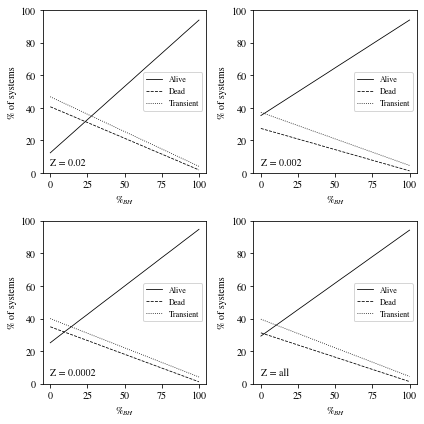

In [305]:
plot_all_ADT()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


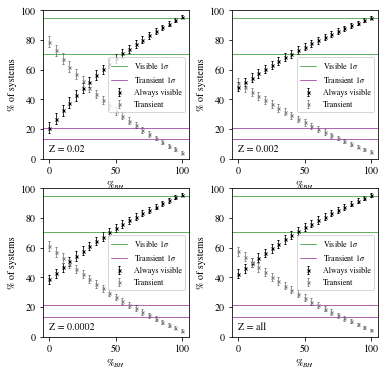

In [306]:
plot_all_AT()